In [27]:
import fonctions as f

In [28]:
# Chemin du fichier CSV
chemin_fichier = './base.csv'  # Remplacez par le chemin réel

# Charger le fichier CSV dans un DataFrame
df = f.pd.read_csv(chemin_fichier)
df.head()

,DATE,RR,TN,HTN,TX,HTX,TM,TMNX,DG,TAMPLI,...,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ETPGRILLE,NEIGETOTX,NEIGETOT06
0,2022-01-05,2.6,-0.4,1759.0,3.4,1217.0,0.9,1.50,389.0,3.8,...,1244.0,99.0,329.0,0.0,1157.0,5.7,88.0,0.4,0.0,0.0
1,2022-01-06,0.0,-2.5,1746.0,4.3,1327.0,-0.6,0.90,964.0,6.8,...,1032.0,99.0,2304.0,0.0,1043.0,5.1,88.0,0.6,0.0,0.0
2,2022-01-07,10.0,-6.9,718.0,1.6,2229.0,-1.2,-2.65,674.0,8.5,...,708.0,99.0,126.0,0.0,1440.0,5.4,96.0,0.0,0.0,0.0
3,2022-01-08,13.2,-0.7,733.0,6.3,2319.0,2.4,2.80,87.0,7.0,...,1403.0,99.0,618.0,0.0,1231.0,6.4,89.0,0.5,0.0,0.0
4,2022-01-09,7.6,0.4,737.0,2.2,601.0,1.8,1.30,0.0,1.8,...,3.0,98.0,745.0,0.0,1440.0,6.5,94.0,0.1,0.0,0.0


# I) Modélisation en utilisant les séries temporelles

## Application de la standardisation pour attenuer l'effet de la saisonnalité des variables

In [29]:
# Initialiser le scaler
scaler = f.StandardScaler()

# Centrer et réduire toutes les colonnes (puisque toutes sont numériques)
df_standardise = f.pd.DataFrame(
    scaler.fit_transform(df.drop(columns='DATE')), 
    index=df.DATE,  # Conserver l'index d'origine (DATE)
    columns=df.drop(columns='DATE').columns  # Conserver les noms des colonnes
)

# Afficher les premières lignes des données transformées
print(df_standardise.head())


                  RR        TN       HTN        TX       HTX        TM  \
DATE                                                                     
2022-01-05 -0.145556 -0.875833  1.400018 -1.730651 -0.406054 -1.480934   
2022-01-06 -0.510261 -1.193486  1.381189 -1.626404  0.071772 -1.689355   
2022-01-07  0.892453 -1.859045 -0.107733 -1.939145  3.989946 -1.772723   
2022-01-08  1.341321 -0.921212 -0.086008 -1.394744  4.380895 -1.272512   
2022-01-09  0.555801 -0.754822 -0.080214 -1.869647 -3.081881 -1.355881   

                TMNX        DG    TAMPLI     TNTXM  ...       HUN        UX  \
DATE                                                ...                       
2022-01-05 -1.464224  0.834364 -1.524584 -1.466111  ... -0.020220  0.423007   
2022-01-06 -1.549044  2.707071 -1.024689 -1.550864  ... -0.573653  0.423007   
2022-01-07 -2.050895  1.762575 -0.741414 -2.059388  ... -1.419465  0.423007   
2022-01-08 -1.280447 -0.149214 -0.991362 -1.282477  ...  0.394854  0.423007   
2022-01


## Séparartion du train et du test


In [45]:
import pandas as pd

# Supposons que df_standardise est déjà trié par ordre chronologique (ancien au récent).
# Si nécessaire, triez-le :
df_standardise = df_standardise.sort_index()  # Si votre index est de type datetime

# Définir la proportion des données pour l'ensemble d'entraînement
train_size = 0.8  # Par exemple, 80% pour l'entraînement

# Calculer l'indice de séparation
train_index = int(len(df_standardise) * train_size)

# Diviser les données
train = df_standardise.iloc[:train_index]  # Les données les plus anciennes
test = df_standardise.iloc[train_index:]   # Les données les plus récentes

# Vérification
print(f"Taille de l'ensemble d'entraînement : {len(train)}")
print(f"Taille de l'ensemble de test : {len(test)}")

# Afficher un aperçu des données
print("Train :")
print(train.tail())
print("\nTest :")
print(test.head())

test.head()

Taille de l'ensemble d'entraînement : 817
Taille de l'ensemble de test : 205
Train :
                  RR        TN       HTN        TX       HTX        TM  \
DATE                                                                     
2024-04-05 -0.510261  0.576296 -0.394510  0.539619  0.097835  0.783912   
2024-04-06 -0.510261  1.196476 -0.413339  0.829194  0.002270  1.228544   
2024-04-07 -0.510261  0.561169 -0.490102  0.910275 -0.023794  1.145175   
2024-04-08  1.229104  0.288895 -0.488654  0.840777  0.206432  0.881175   
2024-04-09 -0.033338 -0.043884  0.025516 -0.838759  1.079551 -0.605564   

                TMNX        DG    TAMPLI     TNTXM  ...       HUN        UX  \
DATE                                                ...                       
2024-04-05  0.599729 -0.432563  0.141735  0.596235  ... -0.302157 -4.526414   
2024-04-06  1.066239 -0.432563 -0.124876  1.062382  ... -0.785106 -8.333661   
2024-04-07  0.818848 -0.432563  0.691620  0.822246  ... -0.304768 -3.955327   
2

,RR,TN,HTN,TX,HTX,TM,TMNX,DG,TAMPLI,TNTXM,...,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ETPGRILLE,NEIGETOTX,NEIGETOT06
DATE,,,,,,,,,,,,,,,,,,,,,
2024-04-10,-0.510261,-0.573306,-0.391613,-0.665014,0.080459,-0.702827,-0.672570,-0.432563,-0.324834,-0.675074,...,0.209507,0.042282,-0.248943,-0.488202,-0.534783,-0.931410,-0.178069,-0.153477,-0.136106,-0.124371
2024-04-11,-0.510261,-0.996844,-0.419132,-0.085864,1.023080,-0.508301,-0.517067,0.352345,0.974895,-0.519691,...,-0.354368,0.042282,-0.231612,-0.488202,-0.354878,-0.781062,-0.261017,0.017698,-0.136106,-0.124371
2024-04-12,-0.482207,-0.754822,-0.520518,0.504870,0.063084,0.005805,-0.043489,-0.432563,1.558107,-0.039419,...,0.159907,0.232644,-0.226280,-0.488202,-0.267737,-0.204730,-0.178069,0.131815,-0.136106,-0.124371
2024-04-13,-0.510261,-0.346411,-0.643629,0.979773,0.488784,0.394859,0.437158,-0.432563,1.791391,0.440853,...,0.392244,0.232644,-0.232946,-0.227065,-0.191839,0.196197,-0.261017,0.474165,-0.136106,-0.124371
2024-04-14,-0.510261,-0.285906,-0.684184,1.072437,0.141274,0.644964,0.521978,-0.432563,1.858044,0.525607,...,0.995276,0.232644,-0.222280,1.174550,-0.354878,0.346545,-0.592807,0.588282,-0.136106,-0.124371


## 1)Test de stationnarité

### a) Représentation de la variable cible

In [30]:
df['DATE'] = f.pd.to_datetime(df['DATE'])

In [31]:
df_standardise.index = f.pd.to_datetime(df_standardise.index)

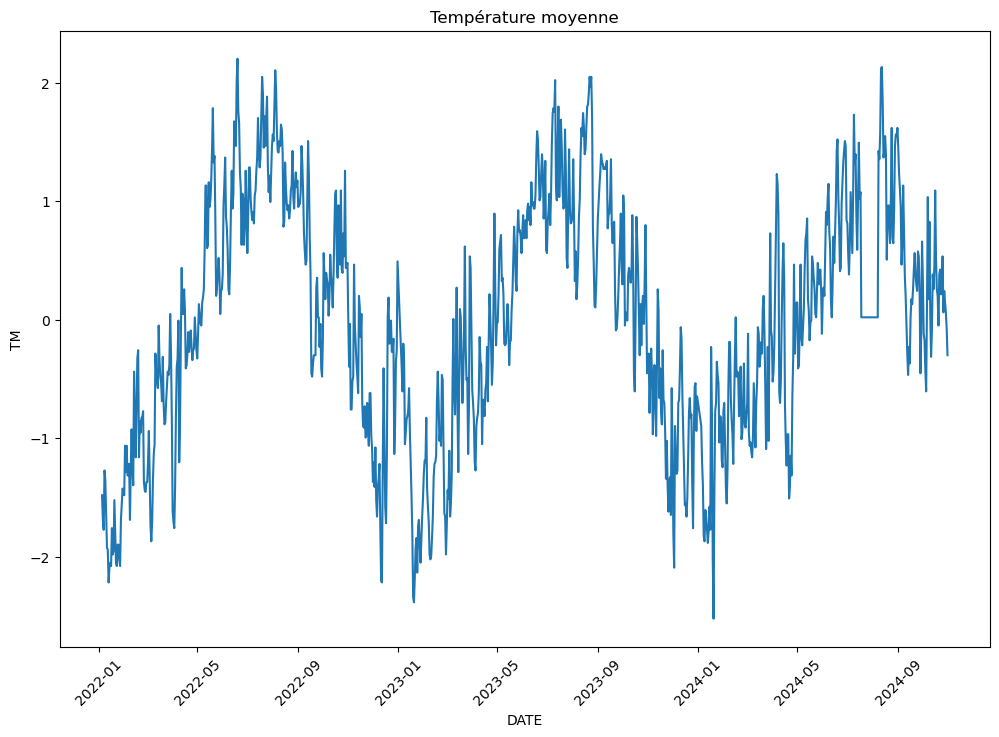

In [32]:
# Configurer la taille des images globalement
f.plt.rcParams['figure.figsize'] = [12, 8]  # Largeur, hauteur en pouces

f.sns.lineplot(x=df_standardise.index, y=df_standardise['TM'])
f.plt.xticks(rotation=45)
f.plt.title("Température moyenne")
f.plt.show()

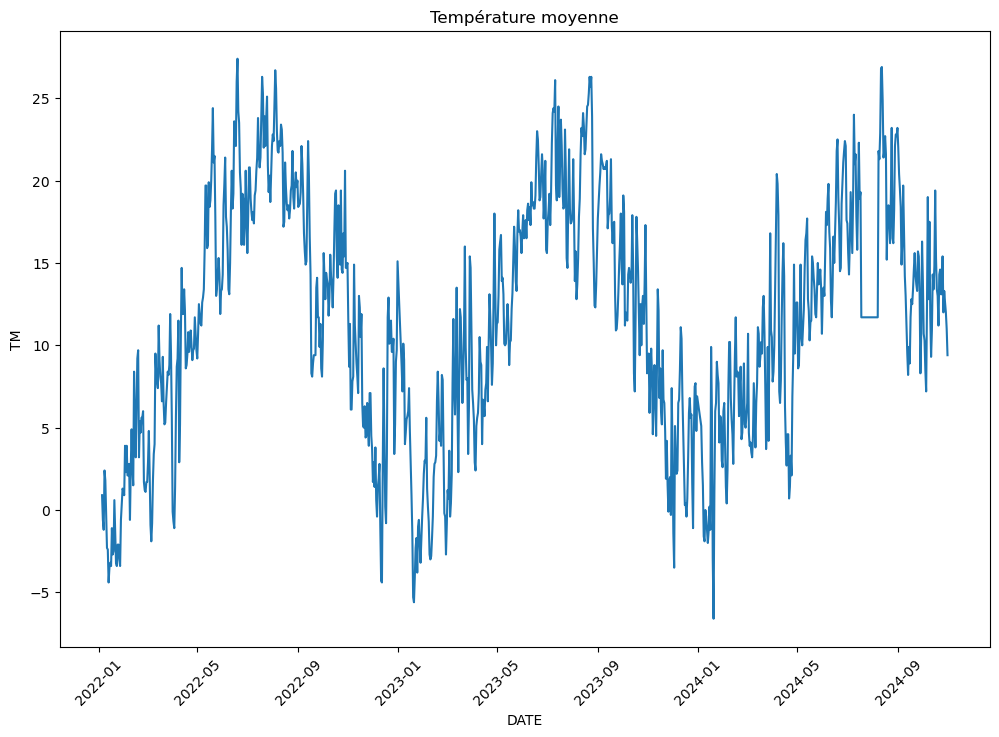

In [33]:
# Configurer la taille des images globalement
f.plt.rcParams['figure.figsize'] = [12, 8]  # Largeur, hauteur en pouces

f.sns.lineplot(x=df['DATE'], y=df['TM'])
f.plt.xticks(rotation=45)
f.plt.title("Température moyenne")
f.plt.show()

Le graphe montre clairement une série temporelle avec des fluctuations saisonnières visibles, ce qui est typique pour des données météorologiques (par exemple, température) sur une période prolongée.

Analyse rapide de la série :
Saisonnalité apparente : On observe des schémas périodiques répétitifs, probablement liés à la saisonnalité annuelle.
Tendance : Il ne semble pas y avoir de tendance linéaire marquée, mais cela peut être confirmé avec des outils statistiques.
Variabilité : Les fluctuations semblent avoir une amplitude relativement constante sur la période.

Répartition des pics :

Les trois pics suggèrent un comportement cyclique qui se répète chaque année.
Cela correspond généralement à un cycle saisonnier lié à des variations climatiques annuelles (par exemple, températures maximales en été et minimales en hiver).
Données journalières :

Puisque les données sont journalières et couvrent trois années, une périodicité de 365 jours est un bon candidat pour modéliser la saisonnalité.
Interprétation des 3 pics :

Chaque pic représente probablement une période similaire dans l'année (comme un maximum en été ou un minimum en hiver).

### b) Décomposition de la série

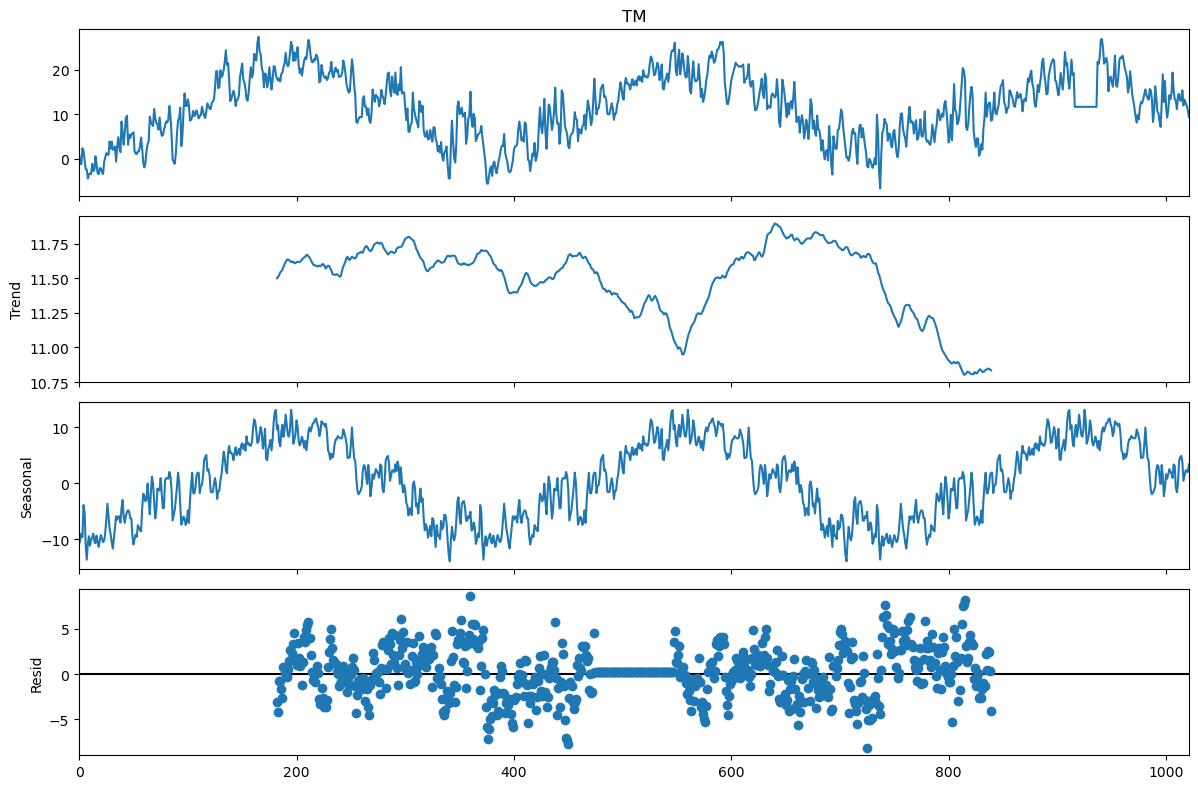

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['TM'], model='additive',  period=365)
result.plot()
f.plt.show()

L'image représente une décomposition classique d'une série temporelle en trois composantes principales : tendance, saisonnalité et résidus.

 Voici une interprétation concise de chaque composante :

 Série temporelle (TM) : Cette courbe représente l'évolution de la température moyenne dans le temps. On observe des fluctuations régulières, ce qui pourrait indiquer une influence saisonnière marquée (par exemple, les cycles annuels).

Tendance (Trend) : La tendance montre une diminution progressive de la température moyenne. Cela pourrait refléter un phénomène climatique local, tel qu'un refroidissement progressif ou des modifications dans les relevés de température au fil du temps.

Saisonnalité (Season) : La composante saisonnière met en évidence des cycles réguliers, typiques des variations climatiques saisonnières (été, hiver, etc.). Ces variations périodiques confirment l'impact des saisons sur les températures moyennes.

Résidus (Resid) : Les résidus montrent les fluctuations aléatoires qui ne sont ni expliquées par la tendance ni par la saisonnalité. Ces variations peuvent être attribuées à des événements exceptionnels, comme des vagues de chaleur, des périodes de froid inhabituelles ou des erreurs de mesure.

En résumé, cette décomposition permet d’identifier une tendance décroissante de la température moyenne, des cycles saisonniers marqués, et des variations aléatoires résiduelles. Si cette analyse fait partie d’un projet, on pourrait approfondir en testant des modèles prédictifs pour la température ou en analysant des facteurs explicatifs (comme des données environnementales ou des événements locaux).

### c) Test proprement dit

a) Test de stationnarité en cherchant le modèle approprié

In [35]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Supposons que df_standardise est déjà défini et contient la colonne 'TM'
tm = df_standardise['TM']

import pandas as pd
import statsmodels.api as sm

def regresser_modele_3(series):
    """
    Ajuste le modèle 3′ : ∆Xt = ϕXt−1 + λ + δt + εt.
    
    Arguments :
    - series : pd.Series, la série temporelle à modéliser.
    
    Retourne :
    - Résultats du modèle ajusté.
    """
    try:
        # Calculer ∆Xt (différences premières de la série)
        delta_Xt = series.diff().dropna()
        
        # Construire les variables explicatives :
        # - Xt-1 : Décalage de la série originale
        # - tendance : série croissante 0, 1, 2, ...
        Xt_minus_1 = series.shift(1).dropna()
        tendance = range(len(delta_Xt))
        
        # Créer le DataFrame des variables explicatives
        X = pd.DataFrame({"Xt-1": Xt_minus_1, "tendance": tendance})
        X = sm.add_constant(X)  # Ajouter la constante λ
        
        # Ajuster le modèle avec OLS (moindres carrés ordinaires)
        model = sm.OLS(delta_Xt, X).fit()
        
        # Afficher le résumé des résultats
        print(model.summary())
        return model
    except Exception as e:
        print(f"Erreur lors de la régression : {e}")
        return None

# Ajuster le modèle 3′
resultat = regresser_modele_3(tm)



                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     18.01
Date:                Fri, 27 Dec 2024   Prob (F-statistic):           2.05e-08
Time:                        15:20:17   Log-Likelihood:                -395.16
No. Observations:                1021   AIC:                             796.3
Df Residuals:                    1018   BIC:                             811.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0099      0.022     -0.442      0.6

On constate que la tendance n'est pas significative. Alors, nous allons passer au modèle 2 avec constante uniquement.

In [36]:
import pandas as pd
import statsmodels.api as sm

def regresser_modele_2(series):
    """
    Ajuste le modèle 2′ : ∆Xt = ϕXt−1 + λ + εt.
    
    Arguments :
    - series : pd.Series, la série temporelle à modéliser.
    
    Retourne :
    - Résultats du modèle ajusté.
    """
    try:
        # Calculer ∆Xt (différences premières de la série)
        delta_Xt = series.diff().dropna()
        
        # Construire les variables explicatives :
        # - Xt-1 : Décalage de la série originale
        Xt_minus_1 = series.shift(1).dropna()
        
        # Créer le DataFrame des variables explicatives
        X = pd.DataFrame({"Xt-1": Xt_minus_1})
        X = sm.add_constant(X)  # Ajouter la constante λ
        
        # Ajuster le modèle avec OLS (moindres carrés ordinaires)
        model = sm.OLS(delta_Xt, X).fit()
        
        # Afficher le résumé des résultats
        print(model.summary())
        return model
    except Exception as e:
        print(f"Erreur lors de la régression : {e}")
        return None

# Exemple d'utilisation
import numpy as np

# Ajuster le modèle 2′
resultat = regresser_modele_2(tm)


                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     35.73
Date:                Fri, 27 Dec 2024   Prob (F-statistic):           3.13e-09
Time:                        15:20:23   Log-Likelihood:                -395.32
No. Observations:                1021   AIC:                             794.6
Df Residuals:                    1019   BIC:                             804.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.011      0.105      0.9

On constate que la constante n'est pas significative. Alors, nous allons passer au modèle 1 sans constante.

In [37]:
import pandas as pd
import statsmodels.api as sm

def regresser_modele_1(series):
    """
    Ajuste le modèle 1′ : ∆Xt = ϕXt−1 + εt (sans constante).
    
    Arguments :
    - series : pd.Series, la série temporelle à modéliser.
    
    Retourne :
    - Résultats du modèle ajusté.
    """
    try:
        # Calculer ∆Xt (différences premières de la série)
        delta_Xt = series.diff().dropna()
        
        # Construire les variables explicatives :
        # - Xt-1 : Décalage de la série originale
        Xt_minus_1 = series.shift(1).dropna()
        
        # Construire le DataFrame sans constante
        X = pd.DataFrame({"Xt-1": Xt_minus_1})
        X = X.loc[delta_Xt.index]  # Aligner les index
        
        # Ajuster le modèle sans constante avec OLS
        model = sm.OLS(delta_Xt, X, hasconst=False).fit()
        
        # Afficher le résumé des résultats
        print(model.summary())
        return model
    except Exception as e:
        print(f"Erreur lors de la régression : {e}")
        return None

# Exemple d'utilisation
import numpy as np

# Ajuster le modèle 1′
resultat = regresser_modele_1(tm)



                                 OLS Regression Results                                
Dep. Variable:                     TM   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.033
Method:                 Least Squares   F-statistic:                              35.76
Date:                Fri, 27 Dec 2024   Prob (F-statistic):                    3.08e-09
Time:                        15:20:28   Log-Likelihood:                         -395.33
No. Observations:                1021   AIC:                                      792.7
Df Residuals:                    1020   BIC:                                      797.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

. Conclusion
P-valeur significative : p value < 0.05, nous rejetons H0
​
 . Le coefficient 𝜙 est négatif et significatif (𝜙 = −0.0667).

Série stationnaire :
Ces résultats indiquent que la série est stationnaire en considérant un modèle sans tendance et sans constante, car il n’y a pas de racine unitaire.

### Test complémentaire de stationnarité

In [38]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss


# Test de Dickey-Fuller augmenté (ADF)
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print("Test Dickey-Fuller Augmenté (ADF):")
    print(f"Statistique de test : {result[0]:.4f}")
    print(f"p-value : {result[1]:.4f}")
    print(f"Valeurs critiques : {result[4]}")
    if result[1] < 0.05:
        print("=> La série est stationnaire (on rejette l'hypothèse nulle).")
    else:
        print("=> La série n'est pas stationnaire (on ne rejette pas l'hypothèse nulle).")

# Test KPSS
def kpss_test(series):
    result = kpss(series, regression='c')
    print("\nTest KPSS:")
    print(f"Statistique de test : {result[0]:.4f}")
    print(f"p-value : {result[1]:.4f}")
    print(f"Valeurs critiques : {result[3]}")
    if result[1] > 0.05:
        print("=> La série est stationnaire (on ne rejette pas l'hypothèse nulle).")
    else:
        print("=> La série n'est pas stationnaire (on rejette l'hypothèse nulle).")

# Exécution des tests
adf_test(df_standardise["TM"])
kpss_test(df_standardise["TM"])

Test Dickey-Fuller Augmenté (ADF):
Statistique de test : -3.5260
p-value : 0.0073
Valeurs critiques : {'1%': np.float64(-3.4368090295897624), '5%': np.float64(-2.864391734279673), '10%': np.float64(-2.5682883916134824)}
=> La série est stationnaire (on rejette l'hypothèse nulle).

Test KPSS:
Statistique de test : 0.2457
p-value : 0.1000
Valeurs critiques : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> La série est stationnaire (on ne rejette pas l'hypothèse nulle).


### Représentation classique de l'ACF et PACF

a) Sur la série initiale

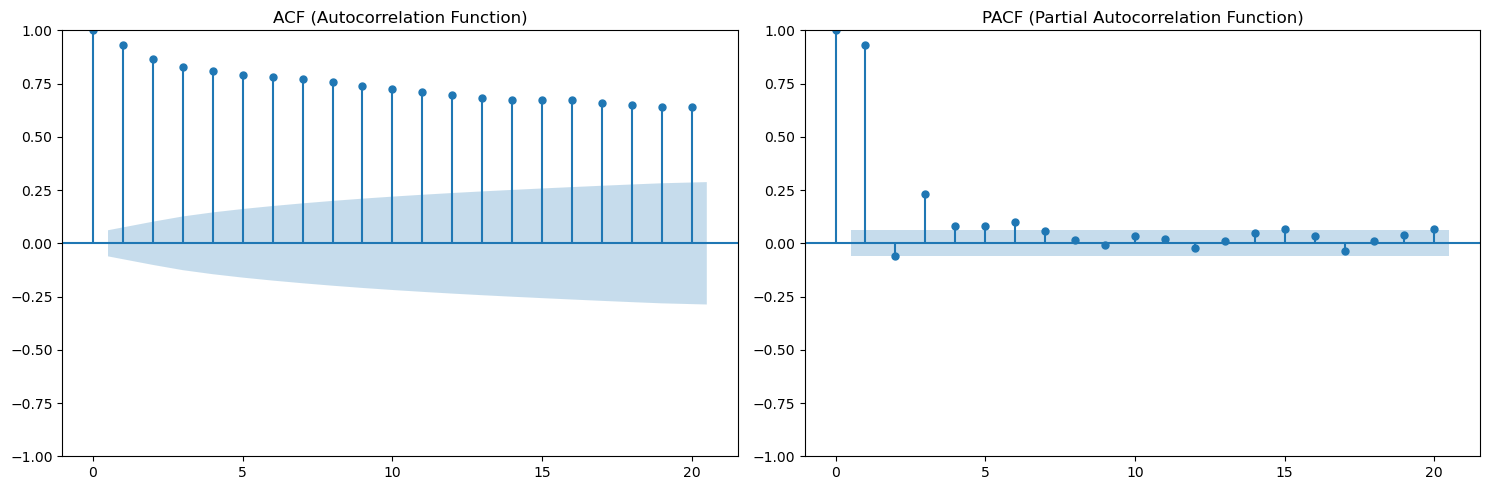

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Tracer l'ACF et le PACF
fig, axes = f.plt.subplots(1, 2, figsize=(15, 5))

# Fonction d'autocorrélation (ACF)
plot_acf(df_standardise["TM"], lags=20, ax=axes[0])
axes[0].set_title('ACF (Autocorrelation Function)')

# Fonction d'autocorrélation partielle (PACF)
plot_pacf(df_standardise["TM"], lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF (Partial Autocorrelation Function)')

f.plt.tight_layout()
f.plt.show()

On constate que la décroissance de l'ACF est très faible,et nous n'arrivons pas vraiment à capter l'effet saisonier. Ce qui est tout à fait logique car nous avons des données journalières et la saisonalité s'étale àprès 365 lags.

b) Sur des lags plus considérables

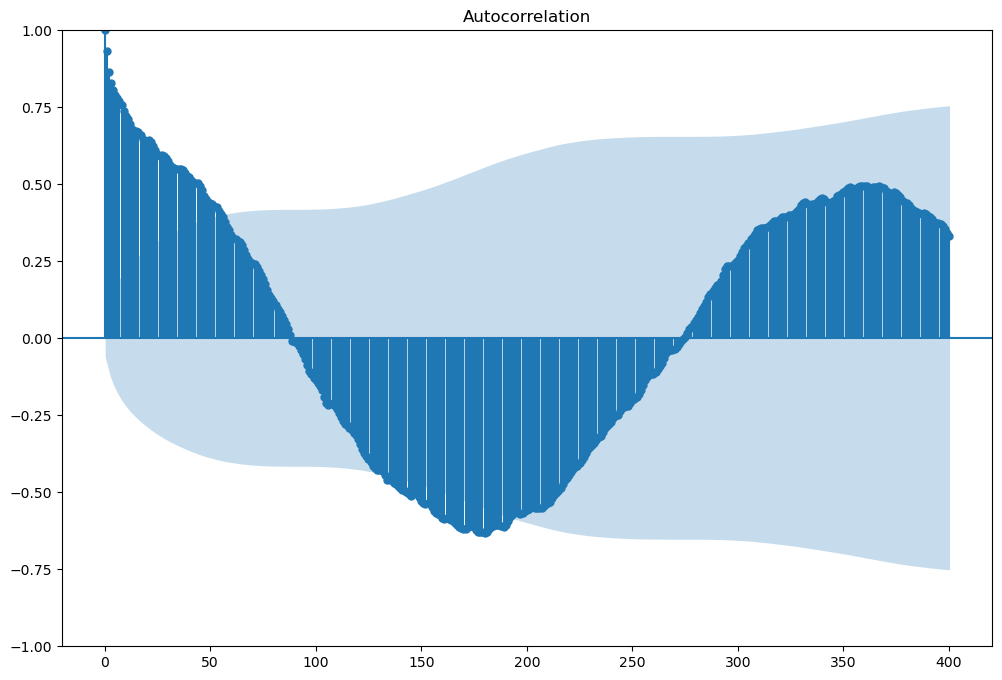

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrélation pour détecter la saisonnalité
plot_acf(df_standardise['TM'], lags=400)  # Ajustez 'lags' pour visualiser jusqu'à un cycle annuel
f.plt.show()

Interprétation du graphe ACF :
Saison régulière autour de 365 jours :

On observe un cycle clair qui diminue progressivement, puis recommence après environ 365 décalages (lags). Cela confirme une saisonnalité annuelle dans vos données (comme anticipé).
Les sommets répétés aux multiples de 365 (ou proches) indiquent que la série est influencée par un effet saisonnier avec une période annuelle.

Diminution progressive des corrélations :

La décroissance lente de l'autocorrélation suggère une tendance persistante ou une non-stationnarité. Cela confirme le besoin de différenciation (au moins D=1) pour rendre la série stationnaire.
Signes de saisonnalité :

Outre la saisonnalité annuelle principale (365 jours), il est possible qu'il y ait des sous-saisonnalités ou des cycles plus courts (par exemple, hebdomadaires ou mensuels), mais ils ne sont pas immédiatement apparents ici.

### Détermination de la valeur de p et q : ACF et PACF en appliquant le modèle 1

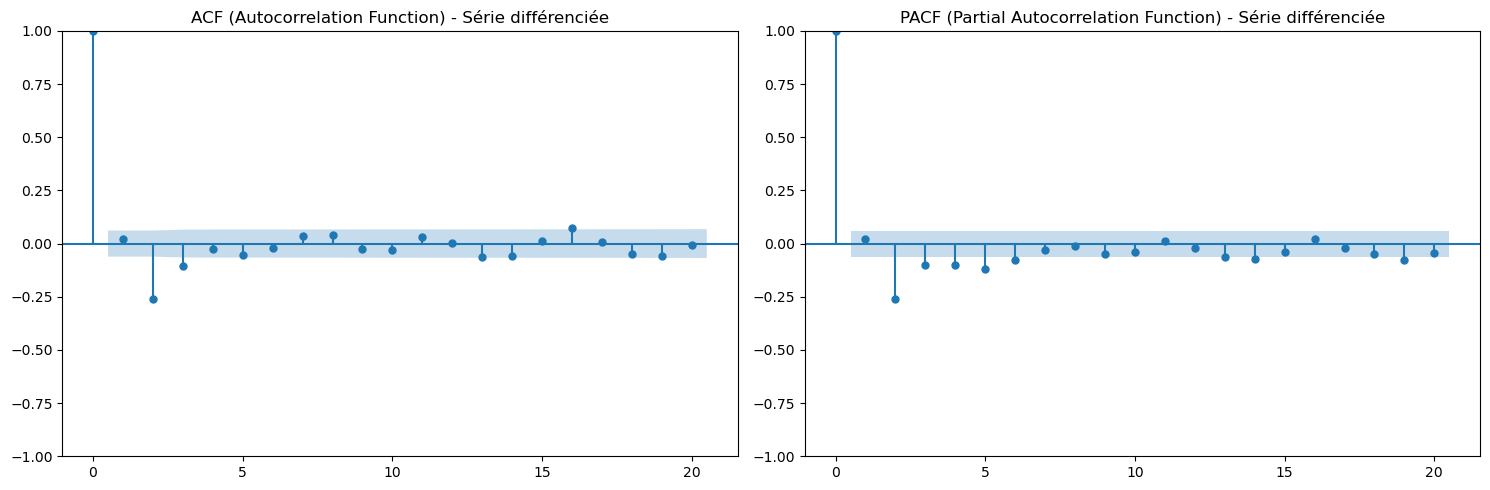

In [44]:
import matplotlib.pyplot as plt

# Calculer la série différenciée (Delta X_t)
tm_diff = df_standardise["TM"].diff().dropna()  # Différence première

# Tracer l'ACF et le PACF de la série différenciée
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Fonction d'autocorrélation (ACF)
plot_acf(tm_diff, lags=20, ax=axes[0])
axes[0].set_title('ACF (Autocorrelation Function) - Série différenciée')

# Fonction d'autocorrélation partielle (PACF)
plot_pacf(tm_diff, lags=20, ax=axes[1], method='ywm')  # "ywm" est robuste
axes[1].set_title('PACF (Partial Autocorrelation Function) - Série différenciée')

f.plt.tight_layout()
f.plt.show()


Pour analyser les différents modèles possibles en fonction des graphiques ACF et PACF, nous utilisons les concepts des modèles ARIMA (p,d,q) où p est l'ordre autorégressif, d est le degré de différenciation, et q est l'ordre du modèle de moyenne mobile.

Dans votre cas :
La série a déjà été différenciée une fois, donc d=1.

Les graphiques ACF et PACF permettent d'identifier les valeurs possibles de p (pour la partie autorégressive AR) et q (pour la partie moyenne mobile MA).

Analyse des valeurs possibles de p et 𝑞

1. Modèle autorégressif (AR) : ACF et PACF
Le PACF montre un pic significatif uniquement au lag 1, ce qui indique un modèle AR(1).
Valeur possible de p : p=1.
D'autres valeurs de p>1 sont peu probables, car les pics au-delà du lag 1 dans la PACF ne sont pas significatifs.

2. Modèle de moyenne mobile (MA) : ACF et PACF
L'ACF diminue rapidement après le lag 1, ce qui est caractéristique d'un modèle AR ou éventuellement d'une faible composante MA.
Valeur possible de q=0 (pas de terme MA significatif).

Une faible composante q=1 pourrait être envisagée si des résidus présentent un certain bruit blanc.

Différents modèles possibles :
En tenant compte de d=1 (série différenciée), les modèles possibles sont :

ARIMA(1, 1, 0) : Un modèle AR(1) sur la série différenciée, cohérent avec votre modèle initial.
ARIMA(1, 1, 1) : Si une petite composante MA est détectée dans les résidus.
​ARIMA(0, 1, 1) : Si l'AR(1) est moins dominant mais une composante MA est présente.
Ici, seule l'ACF serait significative.
ARIMA(0, 1, 0) : Si la série est un bruit blanc différencié (peu probable ici car 𝜙semble significatif).

Résumé :
Les modèles probables : ARIMA(1, 1, 0) ou ARIMA(1, 1, 1). Le choix final dépendra de tests statistiques comme le critère AIC/BIC et l'analyse des résidus.
Si vous souhaitez approfondir l'identification du modèle ou valider les résidus, je peux vous guider dans cette analyse.

### Modélisation

Modèle SARIMA :

En tenant compte de la saisonnalité annuelle, un modèle SARIMA serait pertinent :
SARIMA(1, 1, 0) × (1, 1, 0, 365) ou
SARIMA(1, 1, 1) × (1, 1, 0, 365).


#### Code de manière générale pour les SARIMA

In [46]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour ajuster un modèle SARIMA et afficher les résultats
def fit_sarima_model(df, order, seasonal_order, model_name=""):
    print(f"\n### Modèle {model_name} : SARIMA{order} × {seasonal_order} ###")
    
    # Ajuster le modèle
    model = SARIMAX(df["TM"], order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False, method="lbfgs")
    
    # Résumé du modèle
    print(results.summary())
    
    # Critères AIC et BIC
    aic = results.aic
    bic = results.bic
    print(f"\nCritères : AIC = {aic:.2f}, BIC = {bic:.2f}")
    
    # Résidus du modèle
    residuals = results.resid
    
    # Visualisation des résidus
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(residuals, label="Résidus")
    plt.axhline(0, linestyle="--", color="gray")
    plt.legend()
    plt.title("Résidus")
    plt.subplot(2, 1, 2)
    plot_acf(residuals, lags=50, ax=plt.gca())
    plt.title("ACF des résidus")
    plt.tight_layout()
    plt.show()
    
    # Vérification si les résidus sont du bruit blanc
    print("\nTest des résidus :")
    print("Moyenne des résidus :", np.mean(residuals))
    print("Variance des résidus :", np.var(residuals))
    
    # Prédictions dans la période d'entraînement
    fitted_values = results.fittedvalues
    
    # Calcul des erreurs (RMSE, MAE)
    rmse = np.sqrt(mean_squared_error(df["TM"], fitted_values))
    mae = mean_absolute_error(df["TM"], fitted_values)
    print(f"RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    
    # Visualisation des valeurs observées vs prédites
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df["TM"], label="Valeurs observées", color="blue")
    plt.plot(df.index, fitted_values, label="Valeurs prédites", color="red", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("TM")
    plt.title("Valeurs observées vs Valeurs prédites")
    plt.legend()
    plt.show()
    
    return results, aic, bic, rmse, mae

a) SARIMA(1, 1, 0) × (1, 1, 0, 365)

- Sur le train


### Modèle SARIMA(1, 1, 0) × (1, 1, 0, 12) : SARIMA(1, 1, 0) × (1, 1, 0, 12) ###
                                     SARIMAX Results                                      
Dep. Variable:                                 TM   No. Observations:                  817
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -483.771
Date:                            Fri, 27 Dec 2024   AIC                            973.541
Time:                                    15:35:07   BIC                            987.610
Sample:                                         0   HQIC                           978.944
                                            - 817                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0572      0.034

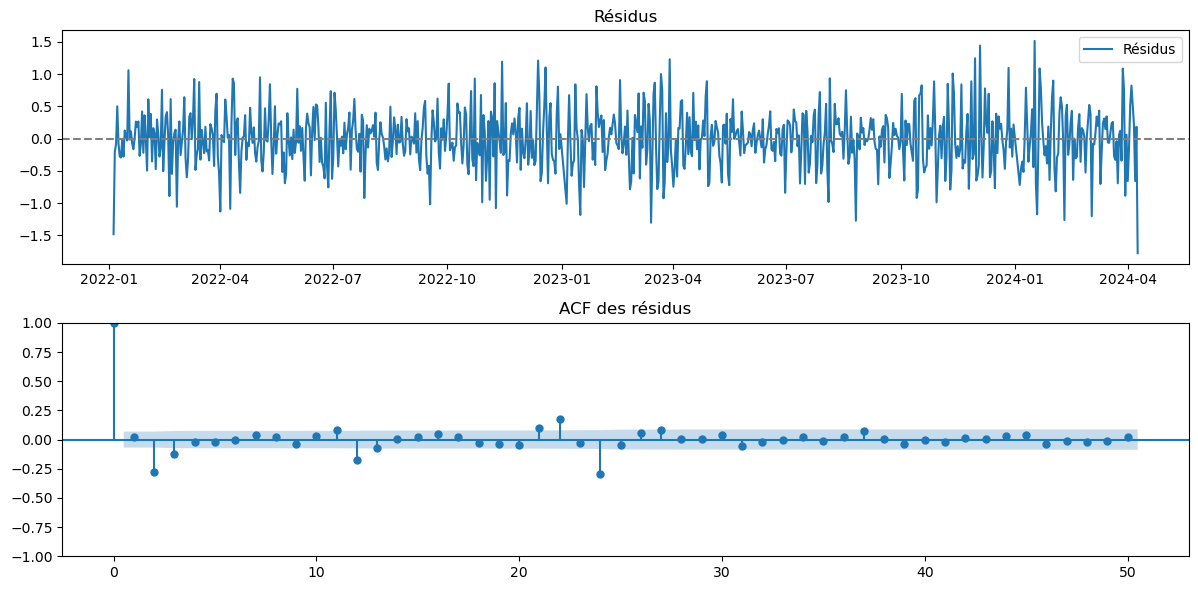


Test des résidus :
Moyenne des résidus : -0.0012678261513359628
Variance des résidus : 0.19598449625769934
RMSE = 0.4427, MAE = 0.3408


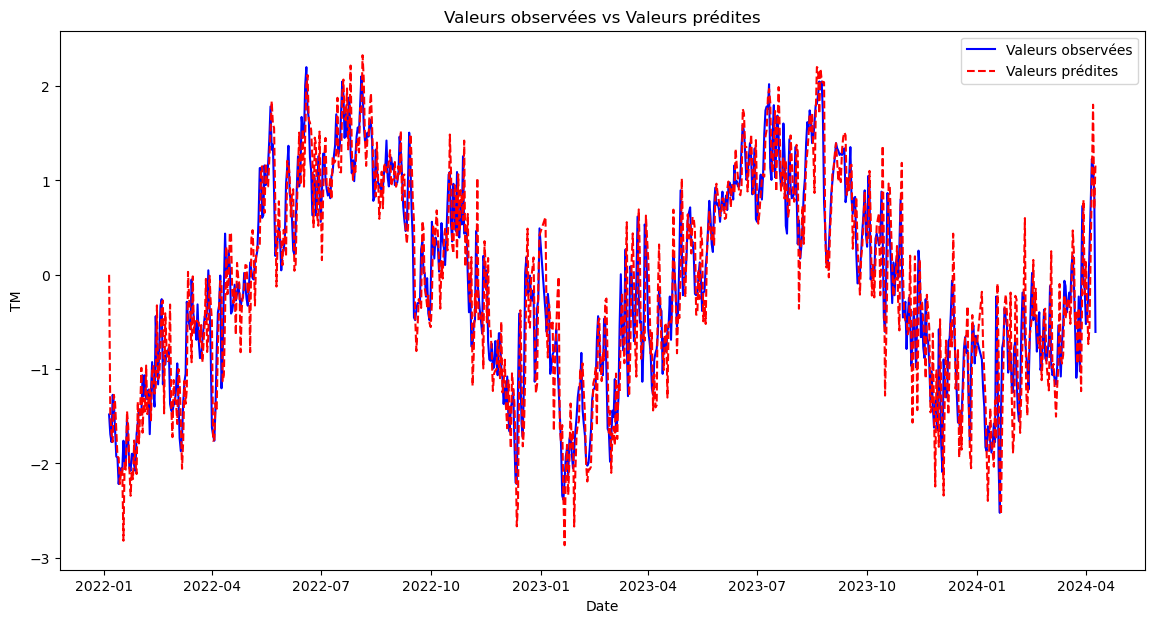

In [47]:
# Modèle SARIMA(1, 1, 0) × (1, 1, 0, 12)
order_1 = (1, 1, 0)
seasonal_order_1 = (1, 1, 0, 12)
results_1, aic_1, bic_1, rmse_1, mae_1 = fit_sarima_model(
    train, order_1, seasonal_order_1, "SARIMA(1, 1, 0) × (1, 1, 0, 12)"
)

- Sur le test


### Modèle SARIMA(1, 1, 0) × (1, 1, 0, 12) : SARIMA(1, 1, 0) × (1, 1, 0, 12) ###
                                     SARIMAX Results                                      
Dep. Variable:                                 TM   No. Observations:                  205
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -118.789
Date:                            Fri, 27 Dec 2024   AIC                            243.579
Time:                                    15:36:15   BIC                            253.351
Sample:                                04-10-2024   HQIC                           247.536
                                     - 10-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0278      0.073

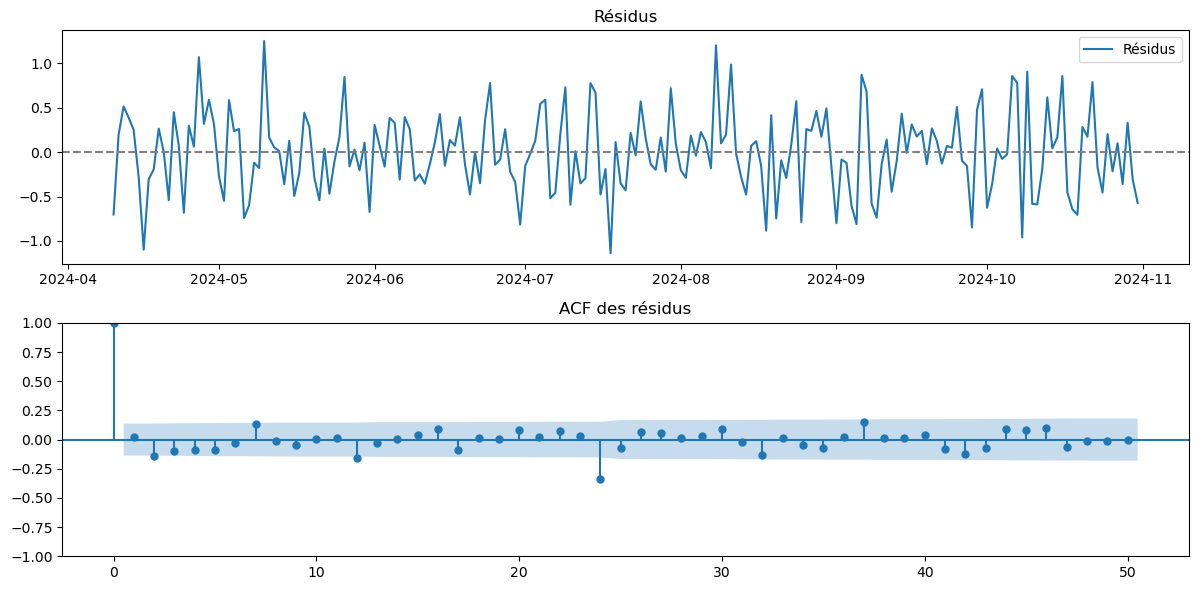


Test des résidus :
Moyenne des résidus : -0.00450362272884995
Variance des résidus : 0.20388172452308495
RMSE = 0.4516, MAE = 0.3596


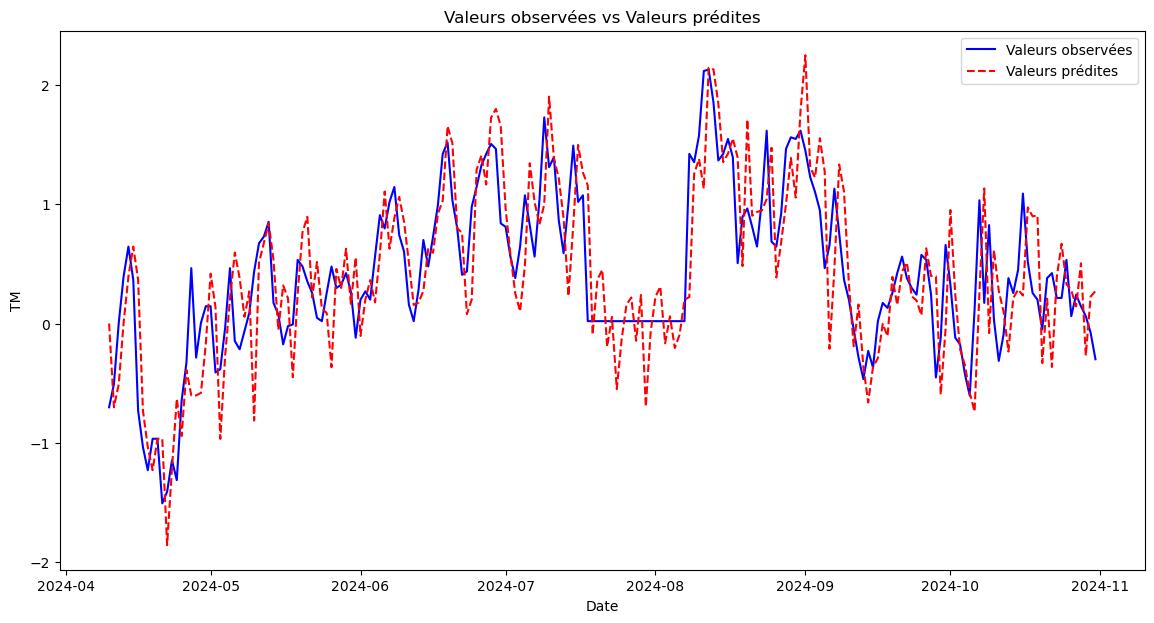

In [48]:
# Modèle SARIMA(1, 1, 0) × (1, 1, 0, 12)
order_1 = (1, 1, 0)
seasonal_order_1 = (1, 1, 0, 12)
results_1, aic_1, bic_1, rmse_1, mae_1 = fit_sarima_model(
    test, order_1, seasonal_order_1, "SARIMA(1, 1, 0) × (1, 1, 0, 12)"
)

b) SARIMA(1, 1, 1) × (1, 1, 0, 365)

- Sur le train


### Modèle SARIMA(1, 1, 1) × (1, 1, 0, 12) : SARIMA(1, 1, 0) × (1, 1, 1, 12) ###
                                      SARIMAX Results                                       
Dep. Variable:                                   TM   No. Observations:                  817
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -351.876
Date:                              Fri, 27 Dec 2024   AIC                            711.752
Time:                                      15:37:06   BIC                            730.510
Sample:                                           0   HQIC                           718.956
                                              - 817                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0

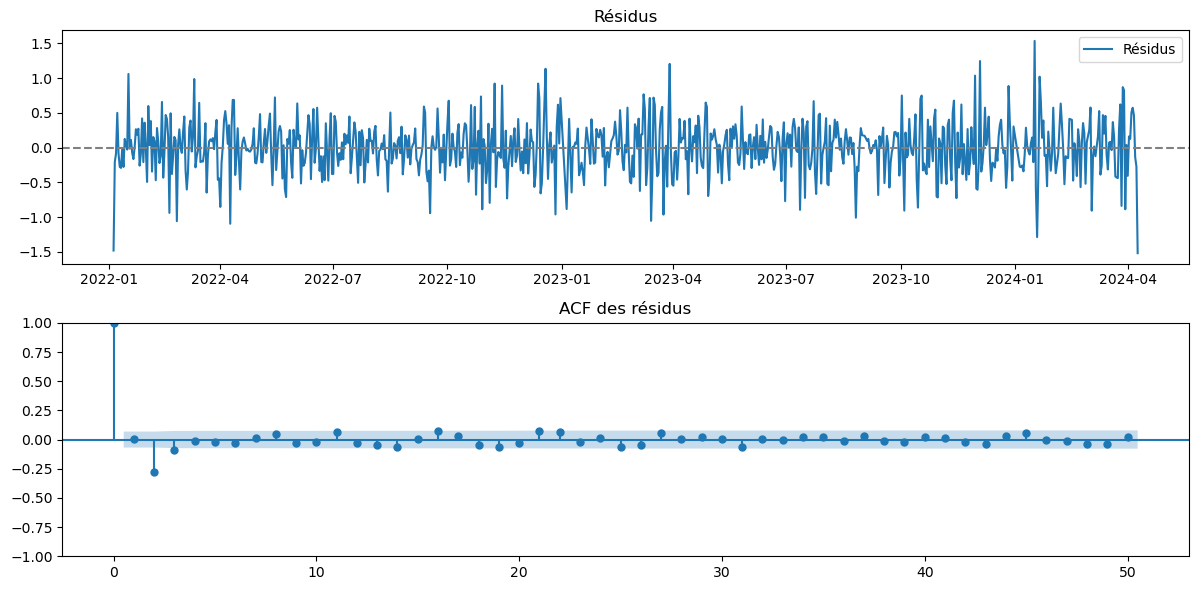


Test des résidus :
Moyenne des résidus : -0.0041138854653597805
Variance des résidus : 0.14154586643317743
RMSE = 0.3762, MAE = 0.2880


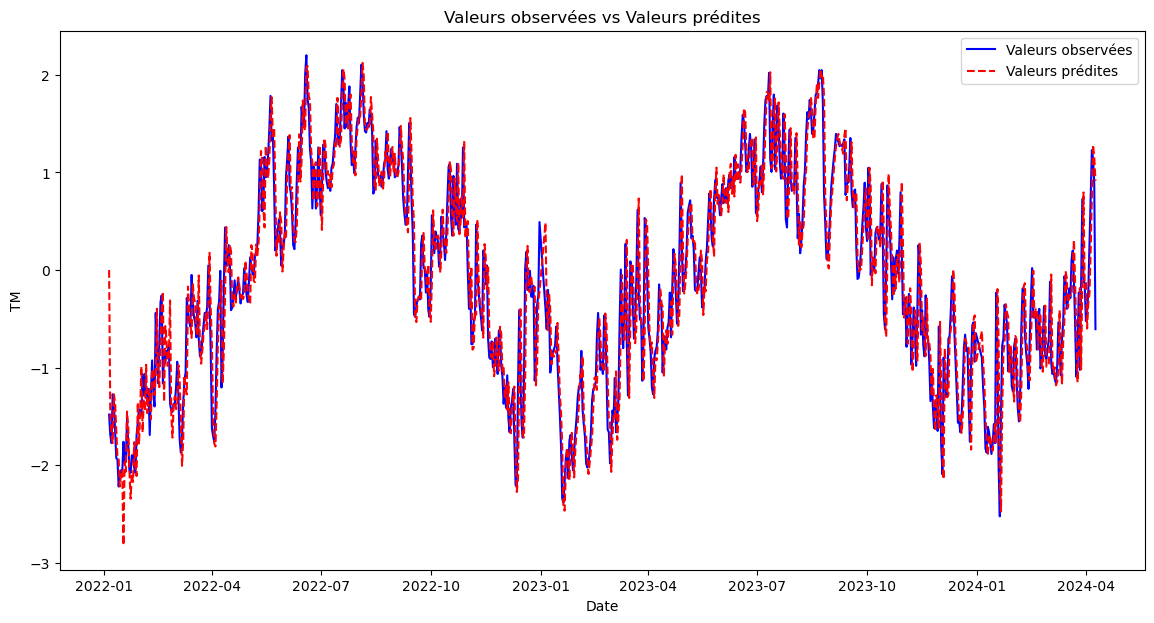

In [49]:
# Modèle SARIMA(1, 1, 1) × (1, 1, 0, 365)
order_2 = (1, 1, 0)
seasonal_order_2 = (1, 1, 1, 12)
results_2, aic_2, bic_2, rmse_2, mae_2 = fit_sarima_model(
    train, order_2, seasonal_order_2, "SARIMA(1, 1, 1) × (1, 1, 0, 12)"
)

- Sur le test


### Modèle SARIMA(1, 1, 1) × (1, 1, 0, 12) : SARIMA(1, 1, 0) × (1, 1, 1, 12) ###
                                      SARIMAX Results                                       
Dep. Variable:                                   TM   No. Observations:                  205
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 -94.806
Date:                              Fri, 27 Dec 2024   AIC                            197.611
Time:                                      15:38:11   BIC                            210.641
Sample:                                  04-10-2024   HQIC                           202.889
                                       - 10-31-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0

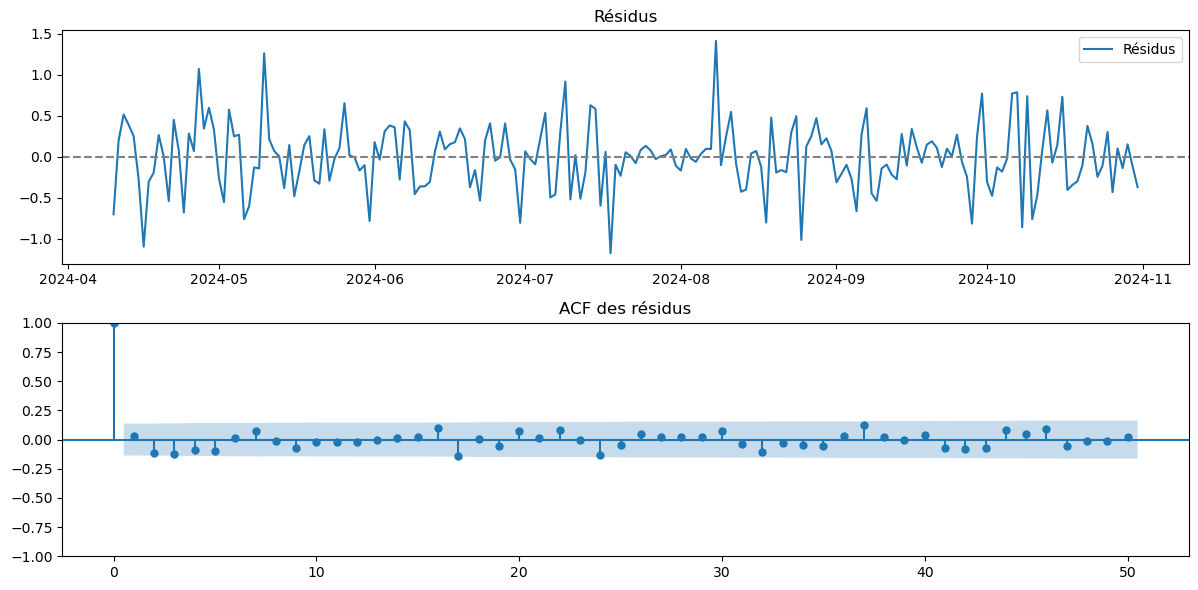


Test des résidus :
Moyenne des résidus : -0.007492554511611313
Variance des résidus : 0.1630838261437544
RMSE = 0.4039, MAE = 0.3067


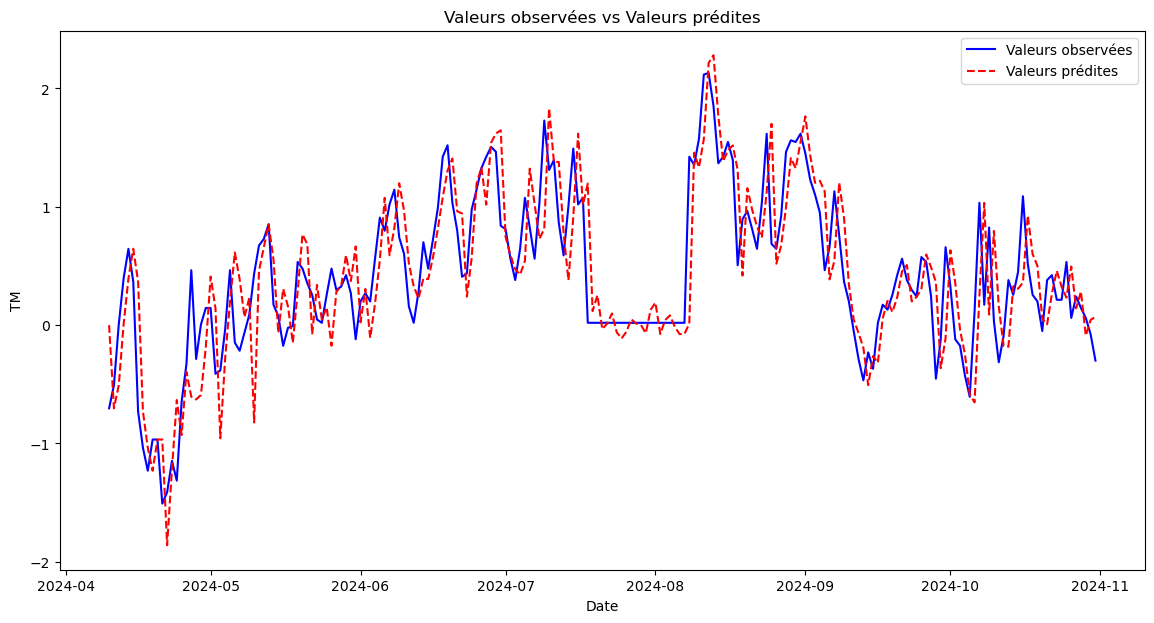

In [50]:
# Modèle SARIMA(1, 1, 1) × (1, 1, 0, 12)
order_2 = (1, 1, 0)
seasonal_order_2 = (1, 1, 1, 12)
results_2, aic_2, bic_2, rmse_2, mae_2 = fit_sarima_model(
    test, order_2, seasonal_order_2, "SARIMA(1, 1, 1) × (1, 1, 0, 12)"
)

c) Comparaison des modèles

In [ ]:
# Comparaison des modèles
#print("\n### Comparaison des modèles ###")
#print(f"SARIMA(1, 1, 0) × (1, 1, 0, 365) : AIC = {aic_1:.2f}, BIC = {bic_1:.2f}, RMSE = {rmse_1:.4f}, MAE = {mae_1:.4f}")
#print(f"SARIMA(1, 1, 1) × (1, 1, 0, 365) : AIC = {aic_2:.2f}, BIC = {bic_2:.2f}, RMSE = {rmse_2:.4f}, MAE = {mae_2:.4f}")

#if aic_1 < aic_2 and rmse_1 < rmse_2:
    #print("\nLe modèle SARIMA(1, 1, 0) × (1, 1, 0, 365) est préférable.")
#else:
    #print("\nLe modèle SARIMA(1, 1, 1) × (1, 1, 0, 365) est préférable.")